In [10]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *

//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [74]:
def create_binary_dataset_salary(salary):    
    """This will create a binary dataset from the csv with a set salary 
    as the threshold for later predictions."""
    
    data = pd.read_csv('../company_x.csv', index_col='employee_id')
    data_with_label = data.copy()
    data_with_label['salary'] = data_with_label['salary'].transform(lambda x: x > salary).astype(int)
    data_with_label['sex'] = data_with_label['sex'].transform(lambda x: x == 'M').astype(int)

    std_data = StandardDataset(df=data_with_label,   
                             label_name='salary',
                             favorable_classes =[1],
                            protected_attribute_names=['sex'], 
                             privileged_classes=[[1]],
                            categorical_features=['degree_level', 'dept'], 
                              features_to_drop=['boss_id'])

    df_data = std_data.convert_to_dataframe()
    binary_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_data[0], label_names=['salary'],
                  protected_attribute_names=['sex'])
    
    return binary_dataset


In [80]:
salary_list = [60000, 150000, 200000, 250000, 300000, 350000]

In [81]:
def create_multiple_datasets(dataset_creator, salary_thresh_list):
    binary_dataset_list = []
    #Create Datasets with Different Salaries 
    for salary in salary_thresh_list:
        binary_dataset = dataset_creator(salary)
        binary_dataset_list.append(binary_dataset)
    return binary_dataset_list


In [82]:
datasets = create_multiple_datasets(create_binary_dataset_salary, salary_list)

In [ ]:
def get_dataset_metrics_list(binary_dataset_list):
    #Set privileged and unprivileged groups
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    
    mean_diff_list = []
    one_minus_disp_imp_list = []
    for dataset in binary_dataset_list:
        metrics = BinaryLabelDatasetMetric(dataset, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)
        mean_diff_list.append(metrics.mean_difference())
        one_minus_disp_imp_list.append(1 - metrics.disparate_impact())
    return mean_diff_list, one_minus_disp_imp_list

In [83]:
def get_dataset_metrics(binary_dataset_list):
    #Set privileged and unprivileged groups
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    
    for dataset in binary_dataset_list:
        display(Markdown("#### Model  dataset metrics"))
        metrics = BinaryLabelDatasetMetric(dataset, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)

        ex_metrics = MetricTextExplainer(metrics)

        print(ex_metrics.mean_difference())
        print('\n')
        print(ex_metrics.disparate_impact())


In [ ]:
means, impact = get_dataset_metrics_list(datasets)


In [59]:
means

[-0.14185487472152958,
 -0.15509419201537045,
 -0.12145545439959105,
 -0.06845718960460986,
 -0.04120975631200614]

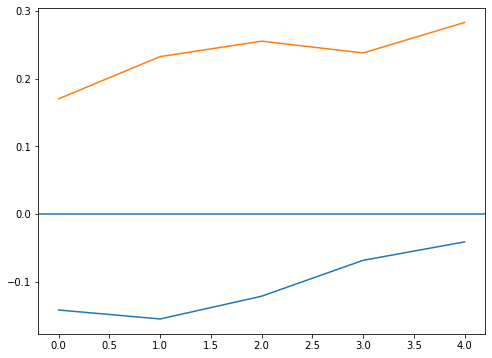

In [84]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(means))

ax.plot(x_axis, means, label='Mean Difference' )
ax.plot(x_axis, impact, label='1 - Disparate Impact')
ax.axhline(0)